In [1]:
% matplotlib inline

from __future__ import division

import glob
import logging
import numpy as np
import os
from fractions import Fraction

import colour
from colour.plotting import *

from colour_demosaicing import (
    demosaicing_CFA_Bayer_bilinear,
    demosaicing_CFA_Bayer_Malvar2004,
    demosaicing_CFA_Bayer_DDFAPD)
from colour_hdri.exif import get_exif_data
from colour_hdri.image import Image, ImageStack, Metadata
from colour_hdri.radiance import radiance_image
from colour_hdri.weighting_functions import (
    hat_function,
    normal_distribution_function,
    weighting_function_Debevec1997)

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.DEBUG)

DIRECTORY = '/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/'

OECF = colour.RGB_COLOURSPACES['sRGB'].transfer_function

def custom_weight_function(a):
    a = np.asarray(a)

    return np.where(a < 0.5,
                   hat_function(a),
                   1)


def process(dng_files, 
            output_directory,
            batch_size=9, 
            post_demosaicing=True,
            weight_function=custom_weight_function,
            CFA_Bayer_pattern='GRBG'):

    for dng_files in colour.batch(dng_files, batch_size):
        image_stack = ImageStack()
        for dng_file in dng_files:
            image = Image(dng_file)
            image.read_metadata()
            image.path = str(dng_file.replace('dng', 'tiff'))
            image.read_data()

            image_stack.append(image)

        if post_demosaicing:
            white_level = max(0, np.max(image_stack.data))

            LOGGER.info('Scaling "{}"...'.format(', '.join(image_stack.path)))
            LOGGER.info('\tBlack Level (Exif)    : {}'.format(image_stack.black_level[0]))
            LOGGER.info('\tWhite Level (Exif)    : {}'.format(image_stack.white_level[0]))
            LOGGER.info('\tWhite Level (Analytic): {}'.format(white_level))
            image_stack.data -= image_stack.black_level[0]
            image_stack.data *= 1 / white_level

        path = os.path.join(
            output_directory,
            '{0}_{1}.{2}'.format(
                os.path.splitext(os.path.basename(image_stack.path[0]))[0],
                batch_size,
                'exr'))

        LOGGER.info('Merging "{0}"...'.format(path))
        image = radiance_image(image_stack, custom_weight_function)

        if post_demosaicing:
            LOGGER.info('Demosaicing "{0}"...'.format(path))
            image = demosaicing_CFA_Bayer_bilinear(image, CFA_Bayer_pattern)
        
        LOGGER.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)
        


DNG_FILES = glob.glob('{0}/*.dng'.format(DIRECTORY))

process(DNG_FILES, DIRECTORY)

INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.dng" image metadata.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2598.tiff" image.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.dng" image metadata.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2599.tiff" image.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.dng" image metadata.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development/colour-science/colour-hdri/colour_hdri/examples/resources/IMG_2600.tiff" image.
INFO:colour_hdri.image:Reading "/Users/kelsolaar/Documents/Development

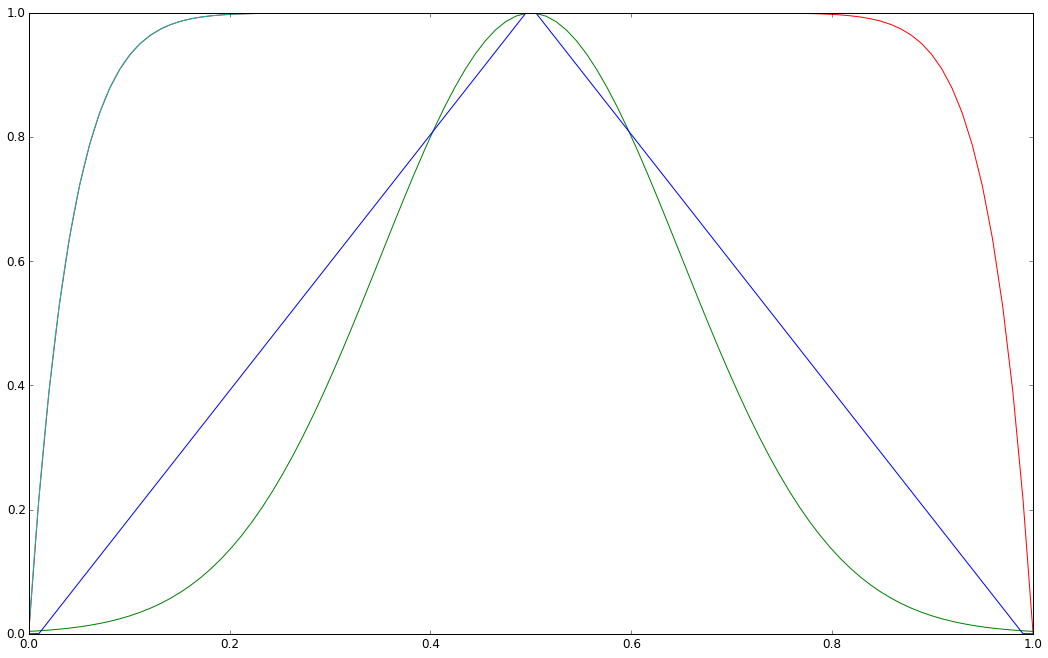

In [2]:
import pylab

pylab.plot(np.linspace(0, 1, 100), hat_function(np.linspace(0, 1, 100)), label='Hat')
pylab.plot(np.linspace(0, 1, 100), normal_distribution_function(np.linspace(0, 1, 100)), label='Normal')
pylab.plot(np.linspace(0, 1, 100), weighting_function_Debevec1997(np.linspace(0, 1, 100)), label='Debevec (1997)')
pylab.plot(np.linspace(0, 1, 1000), custom_weight_function(np.linspace(0, 1, 1000)), label='Custom')

pylab.show()